#### Data Story - Median Cost per watt as a function of time and customer type.

Revisit with cleaned up install_type.  Consolidated install_type is now i_type.

Before I do this I need to clean residential data.  Maybe I should look at commercial data and see if it needs it too...

In [1]:
# %load ../pycode/setup.py
# set up
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

def ecdf(data):
    '''Compute ECDF for a one-dimensional array of measurements.'''
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n + 1) / n
    return x, y

def min015099max(series):
    ''' return list of [ min, 1%, median, 99%, max ] series values '''
    vals = list(np.percentile(series, [1.0, 50.0, 99.0]))
    vals.insert(-1, series.max())
    vals.insert(0, series.min())
    return vals

# ss = np.arange(1, 101)
# min_1_50_99_max(ss)             

def mid98(series):
    '''  return middle 98% of series '''
    bounds = series.quantile([0.01, 0.99])
    return(series[(series > bounds.values[0]) & (series < bounds.values[1])])

# ss = np.arange(1, 101)
# min_1_50_99_max(ss)


In [2]:
# load more concise dataset for exploration
dfLive = pd.read_csv('../local/data/20180101.csv ', index_col='date_installed', parse_dates=True)

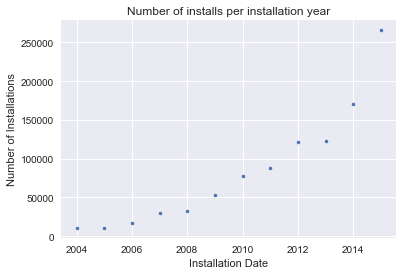

In [3]:
# check to see if it's what I think
dfLive.groupby(dfLive.index.year).size().plot(marker='.', linestyle='none')
plt.title('Number of installs per installation year')
plt.ylabel('Number of Installations')
plt.xlabel('Installation Date');

In [4]:
# all numerical fields
dfLive.describe()

,cost_per_watt,cost,size_kw,zipcode,new_constr,tracking,third_party,bipv
count,745516.000000,7.456290e+05,1.002025e+06,1.002025e+06,27098.0,1920.0,306989.0,5252.0
mean,5.864389,6.531153e+04,1.629462e+01,7.168827e+04,1.0,1.0,1.0,1.0
std,2.026492,4.952030e+05,8.891764e+02,3.564166e+04,0.0,0.0,0.0,0.0
min,0.000000,0.000000e+00,2.000000e-03,0.000000e+00,1.0,1.0,1.0,1.0
25%,4.565217,2.114000e+04,3.750000e+00,6.370100e+04,1.0,1.0,1.0,1.0
50%,5.500000,3.030132e+04,5.500000e+00,9.202600e+04,1.0,1.0,1.0,1.0
75%,7.050000,4.363560e+04,7.905000e+00,9.371100e+04,1.0,1.0,1.0,1.0
max,30.000000,1.522000e+08,7.373190e+05,9.973700e+04,1.0,1.0,1.0,1.0


In [5]:
# non-numeric fields
dfLive.describe(include=np.object)

,state,city,county,appraised,incentive,utility,tech,model,installer,i_type
count,1002025,788849,980790,223431,788415,783186,580399,580399,694390,966720
unique,52,11152,1019,1,65,378,11,3263,10168,8
top,CA,SAN DIEGO,Los Angeles,True,California Public Utilities Commission (Non-CS...,Pacific Gas & Electric Company,Poly,multiple matches,SolarCity,residential
freq,611709,13681,80985,223431,260940,211222,350294,96843,167523,898183


In [6]:
dfRes = dfLive.loc[dfLive.i_type == 'residential']

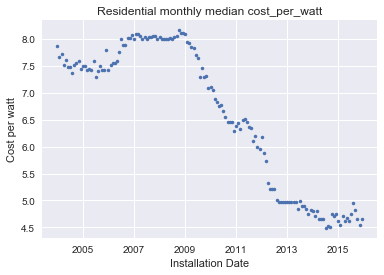

In [7]:
dfRes.resample('M')['cost_per_watt'].median().plot(marker='.', linestyle='none')
plt.title('Residential monthly median cost_per_watt')
plt.ylabel('Cost per watt')
plt.xlabel('Installation Date');

In [8]:
# this is starting to look a lot like what I need
# we needed to have a df to work with.
# dfLive.groupby(['install_type', dfLive.index.year, dfLive.index.month])['cost_per_watt'].median()
# delivers a series.  That's fine, but we need df methods to change the shape into the right form.
tyYeMo = pd.DataFrame(dfLive.groupby(['i_type', dfLive.index.year, dfLive.index.month])['cost_per_watt'].median())
tyYeMo.head()

cost_per_watt
i_type       date_installed date_installed               
agricultural 2004           4                        5.89
                            8                        7.60
             2005           9                        7.96
             2006           3                       11.07
                            5                        7.22

In [9]:
tyYeMo.loc['residential'].head()

cost_per_watt
date_installed date_installed               
2004           1                        7.87
               2                        7.66
               3                        7.71
               4                        7.51
               5                        7.61

In [10]:
# okay, what I want to do is pivot the type into the columns
type(tyYeMo)

pandas.core.frame.DataFrame

In [11]:
# year, Month in rows - cost_per_watt, install_type in columns
yeMo_cpwTy = tyYeMo.unstack('i_type'); yeMo_cpwTy.head(15)

cost_per_watt                                    \
i_type                         agricultural commercial educational government   
date_installed date_installed                                                   
2004           1                        NaN   6.805000    9.696746        NaN   
               2                        NaN   7.562500         NaN   7.735404   
               3                        NaN   8.016250   10.017734        NaN   
               4                       5.89   7.230000    8.786111        NaN   
               5                        NaN   8.140000    8.240000   6.310000   
               6                        NaN   6.928465    7.525000   6.730000   
               7                        NaN   7.808602   10.000000        NaN   
               8                       7.60   7.788333    8.655000  15.898312   
               9                        NaN   7.390000   13.215000   9.880952   
               10                       NaN   7.981291    7.379931   9.705000   
               11                       NaN   7.512381         NaN        NaN   
               12                       NaN   7.270276    9.455694  18.998221   
2005           1                        NaN   8.000000         NaN   7.247033   
               2                        NaN   7.740000    8.530000        NaN   
               3                        NaN   7.430000   10.000000   9.888219   

                                                                         
i_type                         nonprofit residential    unknown utility  
date_installed date_installed                                            
2004           1                7.618437    7.870000        NaN     NaN  
               2               13.809524    7.660000  13.810000     NaN  
               3                     NaN    7.710000   7.690000     NaN  
               4                8.225000    7.510000   7.915000     NaN  
               5               21.980000    7.610000   7.200000     NaN  
               6                6.450000    7.470000   7.781230     NaN  
               7                8.108333    7.478095   8.640000     NaN  
               8                7.962500    7.360000   9.730000     NaN  
               9                8.986492    7.520000   8.014052     NaN  
               10                    NaN    7.540000   7.860000     NaN  
               11                    NaN    7.580000   8.000000     NaN  
               12               7.490000    7.440000   7.290000     NaN  
2005           1                9.815000    7.500000   8.278542     NaN  
               2                8.125000    7.500000   9.180000     NaN  
               3                3.270000    7.410195   8.850000     NaN

In [12]:
# the values of the index are tuples. first element is year(int), 2nd is month(int)
yeMo_cpwTy.index.get_values()[:10]

array([(2004, 1), (2004, 2), (2004, 3), (2004, 4), (2004, 5), (2004, 6),
       (2004, 7), (2004, 8), (2004, 9), (2004, 10)], dtype=object)

In [13]:
def yeMoTup_to_datetime(tup):
    ''' Takes a tuple of the form (year(int), month(int)); returns datetime for first of that month'''
    str = '{}{:02d}{}'.format(tup[0], tup[1], '01')
    return pd.to_datetime(str)

In [14]:
yeMoTup_to_datetime((2004, 1))

Timestamp('2004-01-01 00:00:00')

In [15]:
# now I need to fix the index so that I can use it for plotting
# maybe just make a new column that's a datetime with year and month from existing index
dtYeMo = yeMo_cpwTy.index.map(yeMoTup_to_datetime)

In [16]:
# nice
dtYeMo[:10]

DatetimeIndex(['2004-01-01', '2004-02-01', '2004-03-01', '2004-04-01',
               '2004-05-01', '2004-06-01', '2004-07-01', '2004-08-01',
               '2004-09-01', '2004-10-01'],
              dtype='datetime64[ns]', freq=None)

In [17]:
dt_cpwType = yeMo_cpwTy.set_index(dtYeMo)

In [18]:
dt_cpwType.head()

cost_per_watt                                               \
i_type      agricultural commercial educational government  nonprofit   
2004-01-01           NaN    6.80500    9.696746        NaN   7.618437   
2004-02-01           NaN    7.56250         NaN   7.735404  13.809524   
2004-03-01           NaN    8.01625   10.017734        NaN        NaN   
2004-04-01          5.89    7.23000    8.786111        NaN   8.225000   
2004-05-01           NaN    8.14000    8.240000   6.310000  21.980000   

                                        
i_type     residential unknown utility  
2004-01-01        7.87     NaN     NaN  
2004-02-01        7.66  13.810     NaN  
2004-03-01        7.71   7.690     NaN  
2004-04-01        7.51   7.915     NaN  
2004-05-01        7.61   7.200     NaN

In [19]:
plt.rc('figure', figsize=(10, 6))

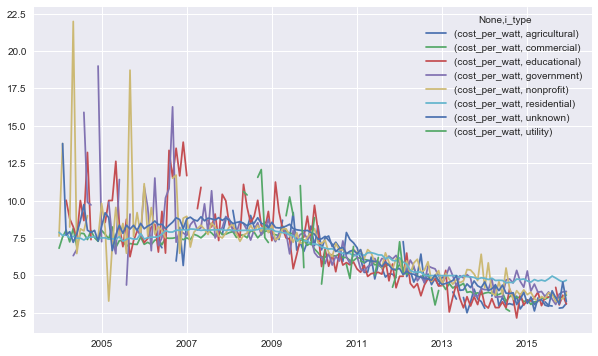

In [20]:
dt_cpwType.plot()

In [21]:
dt_cpwType.columns

MultiIndex(levels=[['cost_per_watt'], ['agricultural', 'commercial', 'educational', 'government', 'nonprofit', 'residential', 'unknown', 'utility']],
           labels=[[0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 2, 3, 4, 5, 6, 7]],
           names=[None, 'i_type'])

In [22]:
# so how do I get to my columns in this multi-index
dt_cpwType.loc[:, (slice(None), ['residential', 'commercial', 'unknown', 
                    'government', 'nonprofit', 'educational'] )].head()

cost_per_watt                                                      
i_type        commercial educational government  nonprofit residential unknown
2004-01-01       6.80500    9.696746        NaN   7.618437        7.87     NaN
2004-02-01       7.56250         NaN   7.735404  13.809524        7.66  13.810
2004-03-01       8.01625   10.017734        NaN        NaN        7.71   7.690
2004-04-01       7.23000    8.786111        NaN   8.225000        7.51   7.915
2004-05-01       8.14000    8.240000   6.310000  21.980000        7.61   7.200

In [23]:
dt_cpwType.loc[:, (slice(None), ['residential', 'commercial', 'unknown', 
                    'government', 'nonprofit', 'educational'])].tail()

cost_per_watt                                               \
i_type        commercial educational government nonprofit residential   
2015-08-01      3.706003         NaN   3.397163  3.760507    4.944088   
2015-09-01      3.499898    4.188811   3.044213  3.225813    4.814330   
2015-10-01      3.535391    3.014136   3.734409  3.404698    4.661990   
2015-11-01      3.531926    3.665946   3.883331  3.435305    4.550795   
2015-12-01      3.676716    3.077250   3.916587  3.830264    4.665583   

                      
i_type       unknown  
2015-08-01  3.959575  
2015-09-01  3.500000  
2015-10-01  3.074000  
2015-11-01  4.550638  
2015-12-01  3.240146

In [24]:
# what are the value_counts again?  I want to leave out the ones with not many installations.
dfLive.i_type.value_counts()

residential     898183
commercial       35950
unknown          19520
government        5702
nonprofit         4220
educational       2572
agricultural       349
utility            224
Name: i_type, dtype: int64

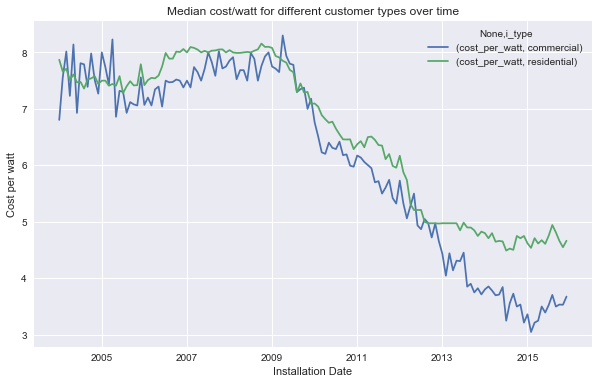

In [25]:
dt_cpwType.loc[:, (slice(None), ['residential', 'commercial'])].plot() 
# marker='.', linestyle='none'
plt.title('Median cost/watt for different customer types over time')
plt.xlabel('Installation Date')
plt.ylabel('Cost per watt');

### What does this chart tell us?

It says:

1. cost per watt declines for all installations from 2005 to 2015.
2. residential customers pay more than commercial customers.

#### What does it make me want to ask?

1. it that strictly a function of size?  
2. are commercial installations generally larger than residential installations?
3. does that vary with time?
4. what is the distribution of size by i_type?  does that vary over time.





In [26]:
byType = dfLive.groupby('i_type')

In [27]:
byType.size_kw.describe()

,count,mean,std,min,25%,50%,75%,max
i_type,,,,,,,,
agricultural,349.0,54.388754,192.500899,0.5700,9.84000,20.460,51.300,3251.28
commercial,35950.0,117.419603,434.520770,0.0400,9.90000,24.705,63.420,18000.00
educational,2572.0,162.975931,364.117021,0.3800,20.44500,63.640,171.395,6108.83
government,5702.0,223.714317,461.754086,0.1300,20.22375,72.380,228.875,10000.00
nonprofit,4220.0,95.156413,242.316759,0.0100,10.56000,25.380,66.550,4778.72
residential,898183.0,7.273613,843.057750,0.0056,3.74880,5.390,7.520,737319.00
unknown,19520.0,64.453779,366.494036,0.1500,3.80000,6.480,11.000,18000.00
utility,224.0,8021.190232,23873.558319,0.9000,710.00000,2303.500,10000.000,333000.00


i_type
agricultural    AxesSubplot(0.125,0.2;0.775x0.68)
commercial      AxesSubplot(0.125,0.2;0.775x0.68)
educational     AxesSubplot(0.125,0.2;0.775x0.68)
government      AxesSubplot(0.125,0.2;0.775x0.68)
nonprofit       AxesSubplot(0.125,0.2;0.775x0.68)
residential     AxesSubplot(0.125,0.2;0.775x0.68)
unknown         AxesSubplot(0.125,0.2;0.775x0.68)
utility         AxesSubplot(0.125,0.2;0.775x0.68)
Name: size_kw, dtype: object

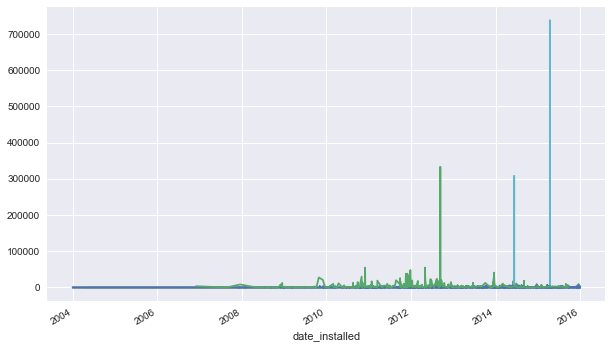

In [28]:
byType.size_kw.plot()

In [29]:
# not working the way I want
# (byType.size_kw).apply(np.log10).plot()

### What does this say?  

It says residential has some wacky data.  The largest utility install is 333 MWatts.  The largest residential install has 737 MWatts.  I don't think so.

Actually I think all of these maximums are broken; probably off by factor of 1000.

In [30]:
# look at res size > 100kw
res_install = (dfLive.i_type == 'residential')

In [31]:
res_install.head()

date_installed
2004-01-01    False
2004-01-01    False
2004-01-01    False
2004-01-01    False
2004-01-01    False
Name: i_type, dtype: bool

In [32]:
res_huge = dfLive.loc[res_install & (dfLive.size_kw > 1000)]

In [33]:
res_huge.size

198

In [34]:
res_huge.head()

,cost_per_watt,cost,size_kw,state,zipcode,city,county,new_constr,tracking,third_party,appraised,incentive,utility,tech,model,installer,bipv,i_type
date_installed,,,,,,,,,,,,,,,,,,
2010-03-15,NaN,NaN,4140.000000,FL,32958,NaN,Indian River,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,residential
2012-11-27,NaN,NaN,1653.312000,NJ,8536,NaN,Middlesex,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,residential
2014-06-10,NaN,NaN,1040.416667,CA,92241,DESERT HOT SPRINGS,Riverside,NaN,NaN,NaN,NaN,California Public Utilities Commission (Non-CS...,Southern California Edison,NaN,NaN,Shorebreak Energy Developers,NaN,residential
2014-06-11,NaN,NaN,307696.000000,CA,95678,Roseville,Placer,NaN,NaN,NaN,NaN,Roseville Electric,Roseville Electric,NaN,NaN,NaN,NaN,residential
2014-12-18,1.870232,3720864.0,1989.520000,MA,2720,Fall River,Bristol,NaN,NaN,1.0,NaN,Massachusetts Department of Energy Resources,National Grid,NaN,NaN,Rexel Energy Solutions,NaN,residential


In [35]:
x, y = ecdf(dfLive.loc[res_install].size_kw)

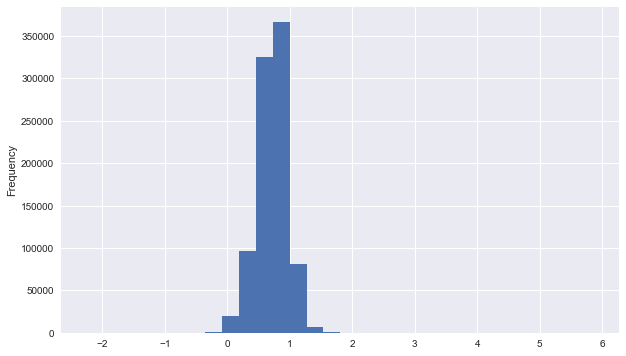

In [36]:
np.log10(dfLive.loc[res_install].size_kw).plot(kind='hist', bins=30);

In [37]:
lose_junk = dfLive.drop(dfLive.loc[res_install & (dfLive.size_kw > 100)].index)

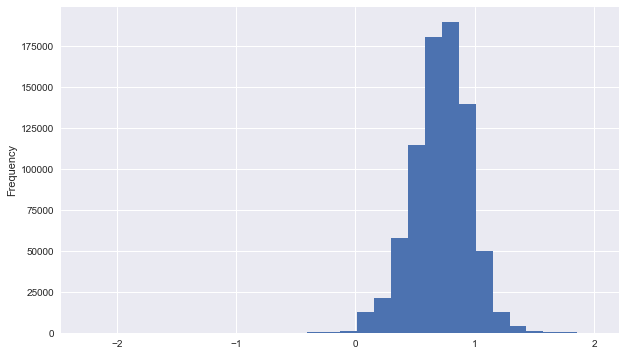

In [38]:
np.log10(lose_junk.loc[lose_junk.i_type == 'residential'].size_kw).plot(kind='hist', bins=30)

In [39]:
theMask = (lose_junk.i_type == 'residential') & lose_junk.size_kw.notnull()

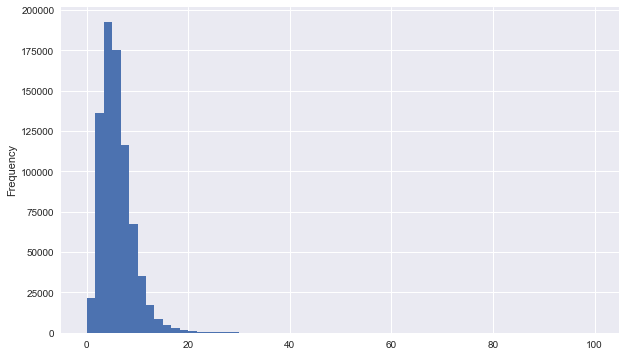

In [40]:
lose_junk.loc[lose_junk.i_type == 'residential'].size_kw.plot(kind='hist', bins=60)

In [41]:
x, y = ecdf(lose_junk.loc[theMask].size_kw)

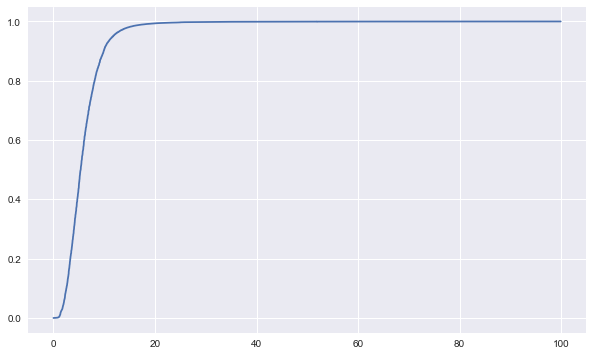

In [42]:
plt.plot(x, y)

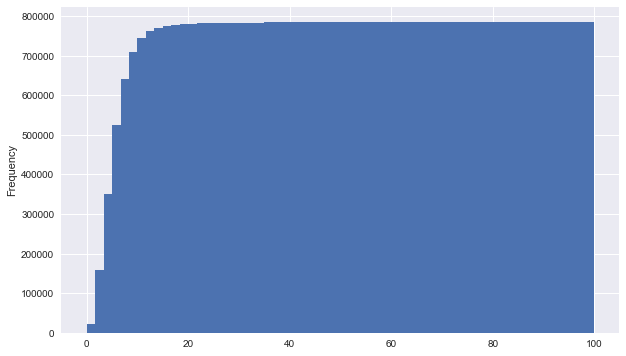

In [43]:
lose_junk.loc[lose_junk.i_type == 'residential'].size_kw.plot(kind='hist', bins=60, cumulative=True)

#### What's a mother to do?

I have to get rid of the crappy data or it'll take way too much time and I'll keep losing the thread.

One sign of crappy data is that there's a null in size_kw or cost or cost_per_watt.
Another sign is that they're all there, but cost_per_watt != size_kw / cost.

In [44]:
zeMask = dfLive.size_kw.notnull() & dfLive.cost.notnull() & dfLive.cost_per_watt.notnull()

In [45]:
maybeLive = dfLive.loc[zeMask]

In [46]:
xx, yy = ecdf(maybeLive.loc[maybeLive.i_type == 'residential'].size_kw)

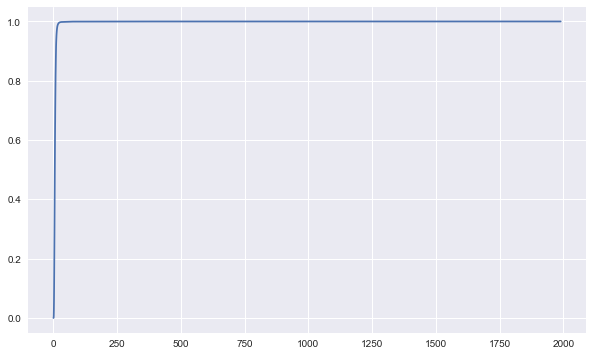

In [47]:
plt.plot(xx, yy)

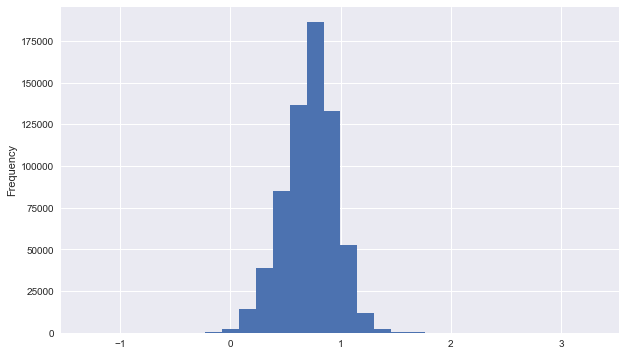

In [48]:
np.log10(maybeLive.loc[maybeLive.i_type == 'residential'].size_kw).plot(kind='hist', bins = 30)

In [49]:
dfLive.count()

cost_per_watt     745516
cost              745629
size_kw          1002025
state            1002025
zipcode          1002025
city              788849
county            980790
new_constr         27098
tracking            1920
third_party       306989
appraised         223431
incentive         788415
utility           783186
tech              580399
model             580399
installer         694390
bipv                5252
i_type            966720
dtype: int64

In [50]:
dfLive.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1002025 entries, 2004-01-01 to 2015-12-31
Data columns (total 18 columns):
cost_per_watt    745516 non-null float64
cost             745629 non-null float64
size_kw          1002025 non-null float64
state            1002025 non-null object
zipcode          1002025 non-null int64
city             788849 non-null object
county           980790 non-null object
new_constr       27098 non-null float64
tracking         1920 non-null float64
third_party      306989 non-null float64
appraised        223431 non-null object
incentive        788415 non-null object
utility          783186 non-null object
tech             580399 non-null object
model            580399 non-null object
installer        694390 non-null object
bipv             5252 non-null float64
i_type           966720 non-null object
dtypes: float64(7), int64(1), object(10)
memory usage: 165.3+ MB


In [51]:
dfLive.describe()

,cost_per_watt,cost,size_kw,zipcode,new_constr,tracking,third_party,bipv
count,745516.000000,7.456290e+05,1.002025e+06,1.002025e+06,27098.0,1920.0,306989.0,5252.0
mean,5.864389,6.531153e+04,1.629462e+01,7.168827e+04,1.0,1.0,1.0,1.0
std,2.026492,4.952030e+05,8.891764e+02,3.564166e+04,0.0,0.0,0.0,0.0
min,0.000000,0.000000e+00,2.000000e-03,0.000000e+00,1.0,1.0,1.0,1.0
25%,4.565217,2.114000e+04,3.750000e+00,6.370100e+04,1.0,1.0,1.0,1.0
50%,5.500000,3.030132e+04,5.500000e+00,9.202600e+04,1.0,1.0,1.0,1.0
75%,7.050000,4.363560e+04,7.905000e+00,9.371100e+04,1.0,1.0,1.0,1.0
max,30.000000,1.522000e+08,7.373190e+05,9.973700e+04,1.0,1.0,1.0,1.0


In [52]:
dfLive.describe(include=np.object)

,state,city,county,appraised,incentive,utility,tech,model,installer,i_type
count,1002025,788849,980790,223431,788415,783186,580399,580399,694390,966720
unique,52,11152,1019,1,65,378,11,3263,10168,8
top,CA,SAN DIEGO,Los Angeles,True,California Public Utilities Commission (Non-CS...,Pacific Gas & Electric Company,Poly,multiple matches,SolarCity,residential
freq,611709,13681,80985,223431,260940,211222,350294,96843,167523,898183
